<a href="https://colab.research.google.com/github/codebluecruz/Getting-started-with-github/blob/master/EDA_on_FinalWebMd_SPolarity_RF_ROC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis w/ Python

This kernel comprise exploratory data analysis on the provided data, including: 
- Data loading
- Data cleaning 
- Descriptive Analysis
- Temporal Analysis
- Sentiment Analysis
- Text Analysis



In [99]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import re
import seaborn as sns
import string
import html
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import normalize, MinMaxScaler
from scipy.stats import spearmanr, pearsonr
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from collections import Counter
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
import warnings; warnings.simplefilter('ignore')
from nltk import ngrams
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer

#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all" # To see all the outputs in the notebook, not only the last one
#pd.set_option('display.max_colwidth', -1) # To see all text in reviews

plt.style.use('ggplot')

## Loading Data

Since we are just doing an exploratory analysis of the data, **we are going to concatenate test and train data into one dataset**.

In [12]:
# Reading data 
drugs = pd.read_csv('WebMd_Final_withSR.csv', skiprows=0)
drugs

,Age,Condition,Date,Drug,DrugId,EaseofUse,Effectiveness,Reviews,Sentiment_Rating,Sex,Sides,UsefulCount,Satisfaction
0,75 or over,Stuffy Nose,9/21/2014,25dph-7.5peh,146724,5,5,I'm a retired physician and of all the meds I have tried for my allergies (seasonal and not) - this one is the most effective for me. When I first began using this drug some years ago - tiredness as a problem but is not currently.,5,Male,"Drowsiness, dizziness , dry mouth /nose/throat, headache , upset stomach , constipation , or trouble sleeping may occur.",0,5
1,25-34,Cold Symptoms,1/13/2011,25dph-7.5peh,146724,5,5,cleared me right up even with my throat hurting it went away after taking the medicine,5,Female,"Drowsiness, dizziness , dry mouth /nose/throat, headache , upset stomach , constipation , or trouble sleeping may occur.",1,5
2,65-74,Other,7/16/2012,warfarin (bulk) 100 % powder,144731,2,3,why did my PTINR go from a normal of 2.5 to over \n100?,5,Female,,0,3
3,75 or over,Other,9/23/2010,warfarin (bulk) 100 % powder,144731,2,2,FALLING AND DON'T REALISE IT,1,Female,,0,1
4,35-44,Other,01-06-2009,warfarin (bulk) 100 % powder,144731,1,1,"My grandfather was prescribed this medication (Coumadin) to assist in blood thinning due to a heart and thyroid condition. His primary doctor was aware that he was on an aspirin regiment and still prescribed this medicine, it caused his blood to thin out to much and he ended up internally bleeding to death. If you are going to take this medicine please ask your doctors about possible side effects or drug interactions.",1,Male,,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99983,45-54,Sensation of Spinning or Whirling,07-02-2008,meclizine hcl,4520,5,3,I used this medicine for vertigo. It is somewhat effective but I had to use it several times before it starts working. However the side effect (drousiness) was severe do I discountinues the medicine.,3,Male,"Drowsiness, dry mouth , and tiredness may occur.",4,2
99984,,Major Depressive Disorder,03-03-2011,mirtazapine tablet,13706,5,5,when I had to go off of it because my insurance out it up higher money wish. I was out of control. I take 60 mg and do very well and stable on it.,5,Female,"Dizziness , drowsiness, lightheadedness , increased appetite, weight gain, dry mouth , or constipation may occur.",1,5
99985,55-64,Other,04-07-2011,mirtazapine,13706,1,1,,5,,"Dizziness , drowsiness, lightheadedness , increased appetite, weight gain, dry mouth , or constipation may occur.",1,1
99986,19-24,Birth Control,1/25/2011,mirena intrauterine device,20420,1,4,I got the mirena in may of 08 after my son was born.. I took Ibprofen as my doc suggested before I got it in.. It hurt really bad I couldnt walk I only lived a mile so I forced myself to drive home.. sat in the tub and took a percocet still didnt help. After that passed I spotted for almost 3 months. I had a ton of side effect coming from a person who has never had side effects from medication before. I got really bad acne (which I had also never had) vaginal discharge with a nasty smell. I gained an extra 30 pounds after having lost all my extra baby wieght before insertion. I got really moody and the number One reason for NEVER reccomending this is I am no longer able to take anything hormonal.. I have alopecia areta its a kind of hair loss you can look up on here it is an autoimmune disease. It went away not too long after I got the Iud removed and the proper medication. but if I take any sort of horomones my hair will fall out again I have about 1/3 of the hair I had originally.,1,Female,"Pain, bleeding, or dizziness during and after placement of the device may occur.",4,1


In [ ]:
drugs = drugs.dropna(how = 'any', axis = 0)
drugs.shape
drugs.columns = drugs.columns.str.lower()
drugs.reset_index(drop = True, inplace = True)
drugs['condition'].isnull().sum(axis = 0)

#dropping unnecessary columns
drugs.drop(['date'], axis=1, inplace=True)


In [22]:
drugs.head()

,age,condition,drug,drugid,easeofuse,effectiveness,reviews,sentiment_rating,sex,sides,usefulcount,satisfaction
0,75 or over,Stuffy Nose,25dph-7.5peh,146724,5,5,I'm a retired physician and of all the meds I have tried for my allergies (seasonal and not) - this one is the most effective for me. When I first began using this drug some years ago - tiredness as a problem but is not currently.,5,Male,"Drowsiness, dizziness , dry mouth /nose/throat, headache , upset stomach , constipation , or trouble sleeping may occur.",0,5
1,25-34,Cold Symptoms,25dph-7.5peh,146724,5,5,cleared me right up even with my throat hurting it went away after taking the medicine,5,Female,"Drowsiness, dizziness , dry mouth /nose/throat, headache , upset stomach , constipation , or trouble sleeping may occur.",1,5
2,65-74,Other,warfarin (bulk) 100 % powder,144731,2,3,why did my PTINR go from a normal of 2.5 to over \n100?,5,Female,,0,3
3,75 or over,Other,warfarin (bulk) 100 % powder,144731,2,2,FALLING AND DON'T REALISE IT,1,Female,,0,1
4,35-44,Other,warfarin (bulk) 100 % powder,144731,1,1,"My grandfather was prescribed this medication (Coumadin) to assist in blood thinning due to a heart and thyroid condition. His primary doctor was aware that he was on an aspirin regiment and still prescribed this medicine, it caused his blood to thin out to much and he ended up internally bleeding to death. If you are going to take this medicine please ask your doctors about possible side effects or drug interactions.",1,Male,,1,1


## Data Cleaning and Data Glimpse

We are willing to check if this dataset have some corrupted data or non present values. 

**condition** is a field which present problems in 1171 registers, probably due to some bug in the data web scraping. The value of those registers is the usefulCount value with an ```span``` HTML tag and the following text: ```users found this comment helpful```. We ignored these registers.

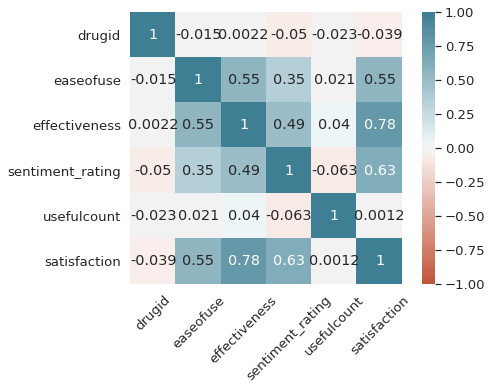

In [24]:
# Heatmap of the correlation matrix
plt.rcParams['figure.figsize'] = [7,5]
sns.set(font_scale = 1.2)
corr = drugs.select_dtypes(include = 'int64').corr()
sns_heat = sns.heatmap(corr, annot = True, vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(20, 220, n=200), square=True);
plt.setp(sns_heat.get_xticklabels(), rotation = 45);

In [25]:
# Let's delete all of these corrupted rows
print("Number of Corrupted Reviews: ", len(drugs[drugs.condition.str.contains(" users found this comment helpful.",na=False)]))
drugs = drugs[~drugs.condition.str.contains(" users found this comment helpful.",na=False)]

Number of Corrupted Reviews:  0


In [26]:
drugs.describe() 

,drugid,easeofuse,effectiveness,sentiment_rating,usefulcount,satisfaction
count,99988.000000,99988.000000,99988.000000,99988.000000,99988.000000,99988.000000
mean,31735.897668,4.028193,3.513882,3.300116,6.689393,3.113674
std,48797.503040,1.303018,1.429267,1.777164,9.086882,1.592108
min,43.000000,1.000000,1.000000,1.000000,0.000000,1.000000
25%,2798.000000,3.000000,3.000000,1.000000,1.000000,1.000000
50%,8486.000000,5.000000,4.000000,4.000000,4.000000,3.000000
75%,20663.000000,5.000000,5.000000,5.000000,9.000000,5.000000
max,178044.000000,5.000000,5.000000,5.000000,154.000000,5.000000


In [30]:
### Thought flow for Depression Confidence Intervals
"""
I want to take the df, filter by condition, drug, confidence interval, sample size cutoff)
Then loop through all the drugs for a specific condition and calculate their
mean, top limit, and bottom limit. 
"""
# Create Confidence Interval Function
def confidence_interval (data, ci_percent):
  data = np.array(data) # Makes sure our data is in a numpy array
  mean = np.mean(data)
  n = len(data)
  stderr = stats.sem(data)
  interval = stderr * stats.t.ppf((1 + ci_percent) / 2., n - 1)
  return (mean, mean - interval, mean + interval)


def condition_compare (drugs, condition_id, ci_percent, sample_size_cutoff):
  output_names = ["Drug Name", "Sample Mean", "Lower Bound", "Upper Bound", "Sample Size"]
  drug_compare = []
  data = drugs[drugs.condition == condition_id]
  for drug in data.drug.unique():
    one_drug = data[data.drug == drug].satisfaction
    if one_drug.size > sample_size_cutoff:
      mean, ilower, iupper= confidence_interval(one_drug, ci_percent)
      entry = [drug, mean, ilower, iupper, one_drug.size]
      drug_compare.append(entry)
  return pd.DataFrame(drug_compare, columns=output_names)


drugs2 = condition_compare(drugs, "Cough", 0.95, 10).sort_values(by="Sample Mean", ascending=False)
drugs2

'\nI want to take the df, filter by condition, drug, confidence interval, sample size cutoff)\nThen loop through all the drugs for a specific condition and calculate their\nmean, top limit, and bottom limit. \n'

,Drug Name,Sample Mean,Lower Bound,Upper Bound,Sample Size
1,mucinex,2.553922,2.333316,2.774528,204
0,mucinex dm,2.551440,2.350144,2.752737,243


In [34]:
drugs['uniqueid'] = np.arange(len(drugs))
drugs

,age,condition,drug,drugid,easeofuse,effectiveness,reviews,sentiment_rating,sex,sides,usefulcount,satisfaction,uniqueid
0,75 or over,Stuffy Nose,25dph-7.5peh,146724,5,5,I'm a retired physician and of all the meds I have tried for my allergies (seasonal and not) - this one is the most effective for me. When I first began using this drug some years ago - tiredness as a problem but is not currently.,5,Male,"Drowsiness, dizziness , dry mouth /nose/throat, headache , upset stomach , constipation , or trouble sleeping may occur.",0,5,0
1,25-34,Cold Symptoms,25dph-7.5peh,146724,5,5,cleared me right up even with my throat hurting it went away after taking the medicine,5,Female,"Drowsiness, dizziness , dry mouth /nose/throat, headache , upset stomach , constipation , or trouble sleeping may occur.",1,5,1
2,65-74,Other,warfarin (bulk) 100 % powder,144731,2,3,why did my PTINR go from a normal of 2.5 to over \n100?,5,Female,,0,3,2
3,75 or over,Other,warfarin (bulk) 100 % powder,144731,2,2,FALLING AND DON'T REALISE IT,1,Female,,0,1,3
4,35-44,Other,warfarin (bulk) 100 % powder,144731,1,1,"My grandfather was prescribed this medication (Coumadin) to assist in blood thinning due to a heart and thyroid condition. His primary doctor was aware that he was on an aspirin regiment and still prescribed this medicine, it caused his blood to thin out to much and he ended up internally bleeding to death. If you are going to take this medicine please ask your doctors about possible side effects or drug interactions.",1,Male,,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99983,45-54,Sensation of Spinning or Whirling,meclizine hcl,4520,5,3,I used this medicine for vertigo. It is somewhat effective but I had to use it several times before it starts working. However the side effect (drousiness) was severe do I discountinues the medicine.,3,Male,"Drowsiness, dry mouth , and tiredness may occur.",4,2,99983
99984,,Major Depressive Disorder,mirtazapine tablet,13706,5,5,when I had to go off of it because my insurance out it up higher money wish. I was out of control. I take 60 mg and do very well and stable on it.,5,Female,"Dizziness , drowsiness, lightheadedness , increased appetite, weight gain, dry mouth , or constipation may occur.",1,5,99984
99985,55-64,Other,mirtazapine,13706,1,1,,5,,"Dizziness , drowsiness, lightheadedness , increased appetite, weight gain, dry mouth , or constipation may occur.",1,1,99985
99986,19-24,Birth Control,mirena intrauterine device,20420,1,4,I got the mirena in may of 08 after my son was born.. I took Ibprofen as my doc suggested before I got it in.. It hurt really bad I couldnt walk I only lived a mile so I forced myself to drive home.. sat in the tub and took a percocet still didnt help. After that passed I spotted for almost 3 months. I had a ton of side effect coming from a person who has never had side effects from medication before. I got really bad acne (which I had also never had) vaginal discharge with a nasty smell. I gained an extra 30 pounds after having lost all my extra baby wieght before insertion. I got really moody and the number One reason for NEVER reccomending this is I am no longer able to take anything hormonal.. I have alopecia areta its a kind of hair loss you can look up on here it is an autoimmune disease. It went away not too long after I got the Iud removed and the proper medication. but if I take any sort of horomones my hair will fall out again I have about 1/3 of the hair I had originally.,1,Female,"Pain, bleeding, or dizziness during and after placement of the device may occur.",4,1,99986


In [32]:
# We will use this groupings later on...

print("Number of Reviews per Drug")
# Number of reviews per drug
reviews_per_drug = drugs.groupby(["drug"]).agg({
    "uniqueid": pd.Series.nunique
})
reviews_per_drug.describe()


print("Number of Reviews per Condition")
# Number of reviews per condition
reviews_per_condition = drugs.groupby(["condition"]).agg({
    "uniqueid": pd.Series.nunique
})

reviews_per_condition.describe()

Number of Reviews per Drug


,uniqueid
count,1341.000000
mean,74.562267
std,298.885689
min,1.000000
25%,2.000000
50%,5.000000
75%,23.000000
max,4267.000000


Number of Reviews per Condition


,uniqueid
count,846.000000
mean,118.189125
std,780.561030
min,1.000000
25%,2.000000
50%,7.000000
75%,35.000000
max,12973.000000


#### Some RegEx to clean this text up. 

In [35]:
# Clean up text with RegEx
pd.set_option('display.width', 1000)
rx_pat = r"(\\r)|(\\n)|(\\t)|(\\f)|(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])|(&#039;)|(\d\s)|(\d)|(\/)"
rx_pat_wSpace = r"(\-)|(\\)|(\s{2,})"
    
drugs['reviews'].replace(regex=True,inplace=True,to_replace=rx_pat, value=r'')
drugs['reviews'].replace(regex=True,inplace=True,to_replace=rx_pat_wSpace, value=r' ')
drugs.reviews.head(5)

0    Im a retired physician and of all the meds I have tried for my allergies seasonal and not   this one is the most effective for me When I first began using this drug some years ago   tiredness as a problem but is not currently                                                                                                                                                                                              
1    cleared me right up even with my throat hurting it went away after taking the medicine                                                                                                                                                                                                                                                                                                                                         
2    why did my PTINR go from a normal of to over                                                                                                             

In [36]:
#club ratings into sentiment_rate
drugs['sentiment_rate'] = drugs["satisfaction"].apply(lambda x: 2 if x > 3 else (1 if ((x>1)&(x<=3)) else 0))
solution = drugs['sentiment_rate']
# Inspect the cleaned text. 
drugs['reviews'] = drugs['reviews'].str.lower()
drugs.head(5)


,age,condition,drug,drugid,easeofuse,effectiveness,reviews,sentiment_rating,sex,sides,usefulcount,satisfaction,uniqueid,sentiment_rate
0,75 or over,Stuffy Nose,25dph-7.5peh,146724,5,5,im a retired physician and of all the meds i have tried for my allergies seasonal and not this one is the most effective for me when i first began using this drug some years ago tiredness as a problem but is not currently,5,Male,"Drowsiness, dizziness , dry mouth /nose/throat, headache , upset stomach , constipation , or trouble sleeping may occur.",0,5,0,2
1,25-34,Cold Symptoms,25dph-7.5peh,146724,5,5,cleared me right up even with my throat hurting it went away after taking the medicine,5,Female,"Drowsiness, dizziness , dry mouth /nose/throat, headache , upset stomach , constipation , or trouble sleeping may occur.",1,5,1,2
2,65-74,Other,warfarin (bulk) 100 % powder,144731,2,3,why did my ptinr go from a normal of to over,5,Female,,0,3,2,1
3,75 or over,Other,warfarin (bulk) 100 % powder,144731,2,2,falling and dont realise it,1,Female,,0,1,3,0
4,35-44,Other,warfarin (bulk) 100 % powder,144731,1,1,my grandfather was prescribed this medication coumadin to assist in blood thinning due to a heart and thyroid condition his primary doctor was aware that he was on an aspirin regiment and still prescribed this medicine it caused his blood to thin out to much and he ended up internally bleeding to death if you are going to take this medicine please ask your doctors about possible side effects or drug interactions,1,Male,,1,1,4,0


## Descriptive Analysis


### Top 10 Reviewed Drugs

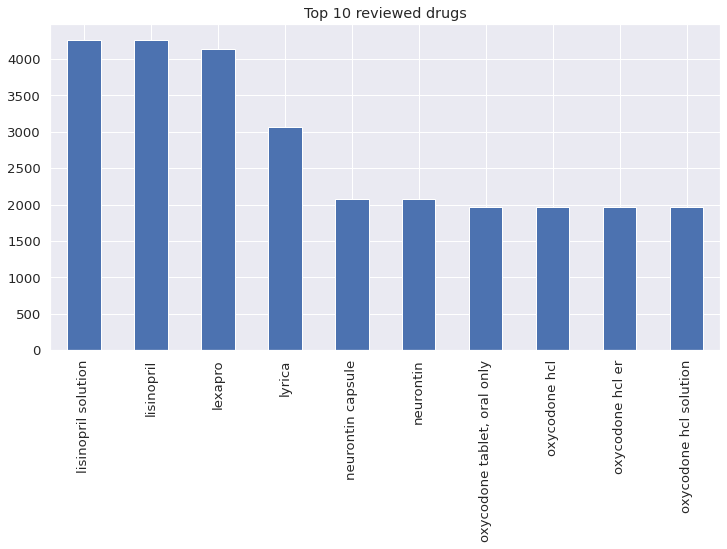

In [38]:
# Top 10 most reviewed drug names
plot = drugs.drug.value_counts().nlargest(10).plot(kind='bar', title="Top 10 reviewed drugs", figsize=(12,6))

### Top 10 conditions undergoing by drug reviewers

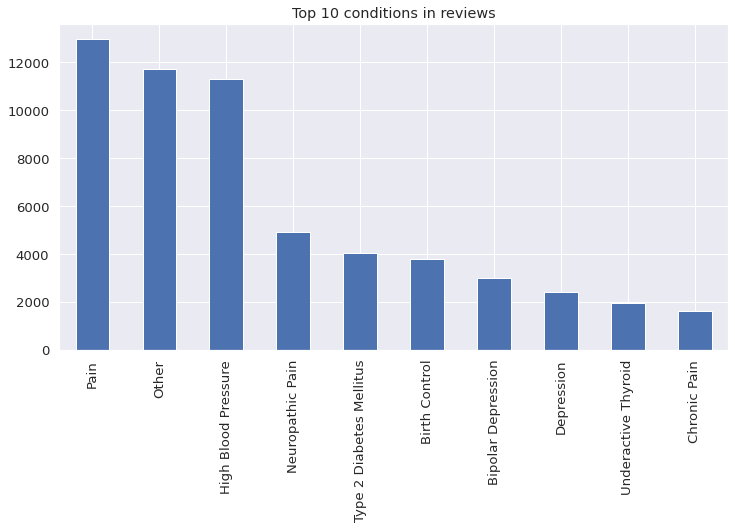

In [39]:
# Top 10 most suffered condition by reviewers
plot = drugs.condition.value_counts().nlargest(10).plot(kind='bar', title="Top 10 conditions in reviews", figsize=(12,6))

### Top 10 drugs with best and worst rating

When doing this analysis for all the drugs, there is a factor which affect the results: **the number of reviews of a drug**. I.e. if we want to compute the drug with best rating, the drug which in **only 1 review** was given a 10 rating would be in TOP 1. For this reason, we only consider drugs with a significant number of reviews. A significant number of reviews is when the number of reviews for a drug is above the 75% of the number of reviews distribution per drug.


Significant number of reviews: More than 23.0 reviews


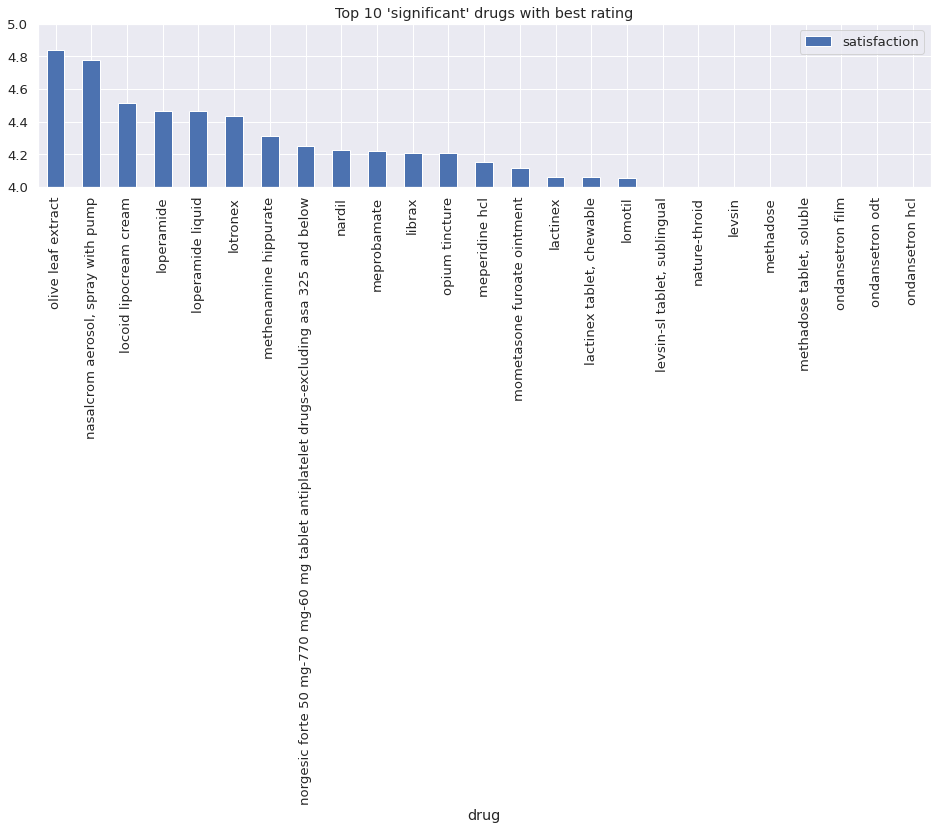

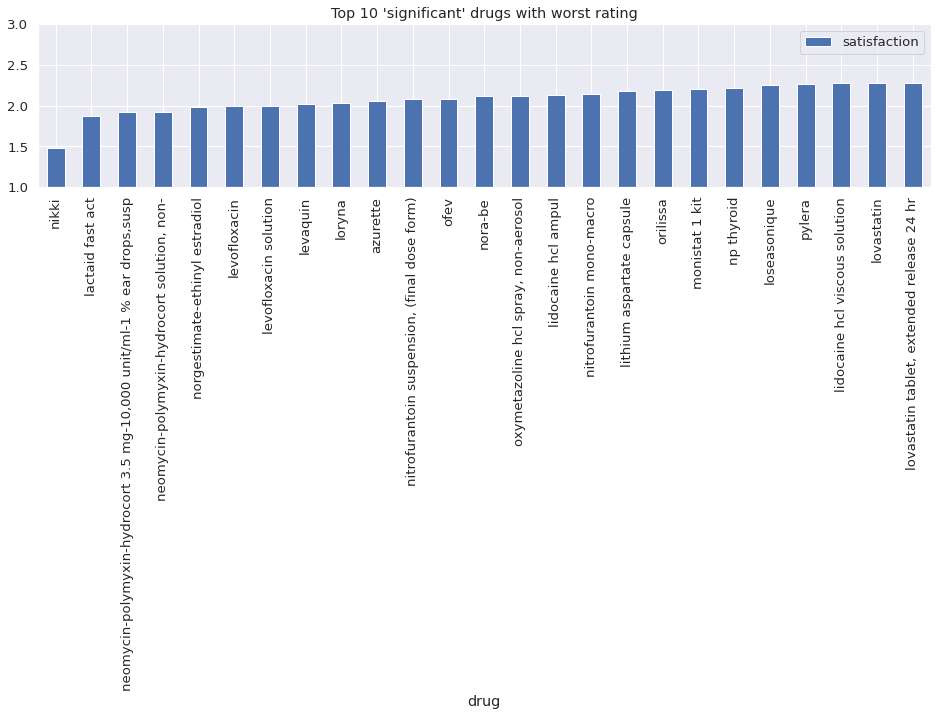

In [46]:
drugs_rating = drugs.groupby('drug').agg({
    'satisfaction': np.mean,
    'uniqueid': pd.Series.nunique
})

print("Significant number of reviews: More than", reviews_per_drug.quantile(q=0.75).values[0], "reviews")

# We only use the drugs which number of reviews is higher than a threshold
drugs_rating = drugs_rating[drugs_rating['uniqueid'] > int(reviews_per_drug.quantile(q=0.75))]

# Top 10
top_drugs_rating = drugs_rating.nlargest(10, 'satisfaction')
plot = top_drugs_rating.plot(y='satisfaction', kind='bar', figsize = (16, 3))
dummy = plt.title("Top 10 'significant' drugs with best rating") # Assigned to variable to prevent output
dummy = plt.ylim(4, 5) # Assigned to variable to prevent output

# Bottom 10
bottom_drugs_rating = drugs_rating.nsmallest(10, 'satisfaction')
plot = bottom_drugs_rating.plot(y='satisfaction', kind='bar', figsize = (16, 3))
dummy = plt.title("Top 10 'significant' drugs with worst rating") # Assigned to variable to prevent output
dummy = plt.ylim(1, 3) # Assigned to variable to prevent output

### Analyzing Pairs (Drug, Condition) with best and worst ratings

We theorize that the rating of a drug, is strongly related to the condition that the person who reviewed was suffering. We are going to compute the top 10 best and worst rating of reviews for (Drug, condition) pairs.

Number of pairs (Drug, Condition): 4286
Significant number of reviews: More than 10.0 reviews


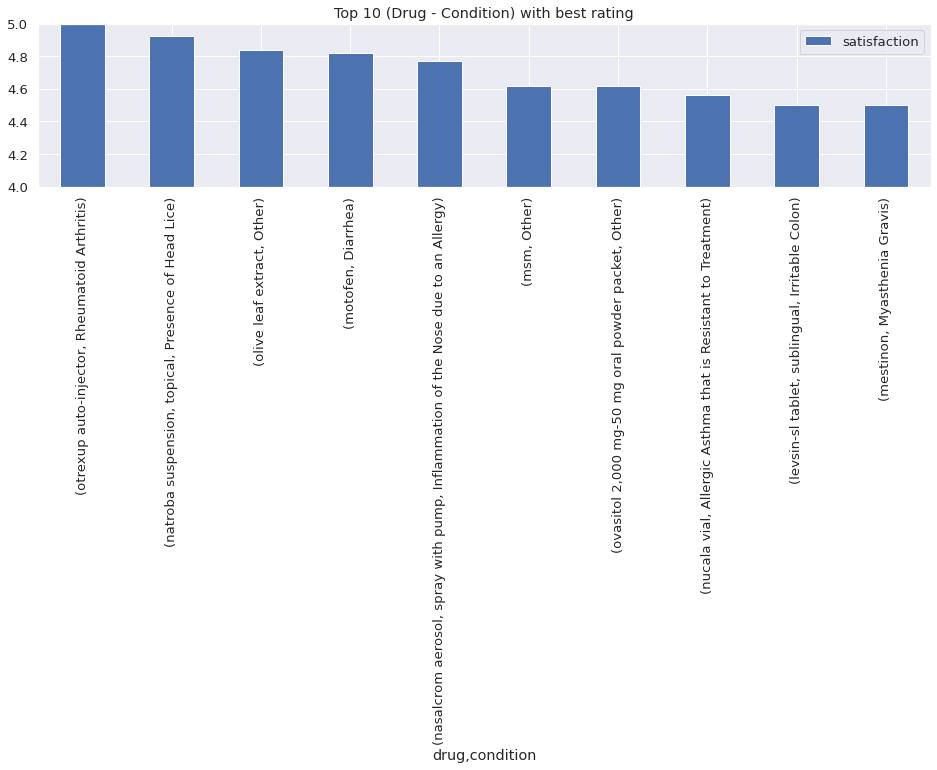

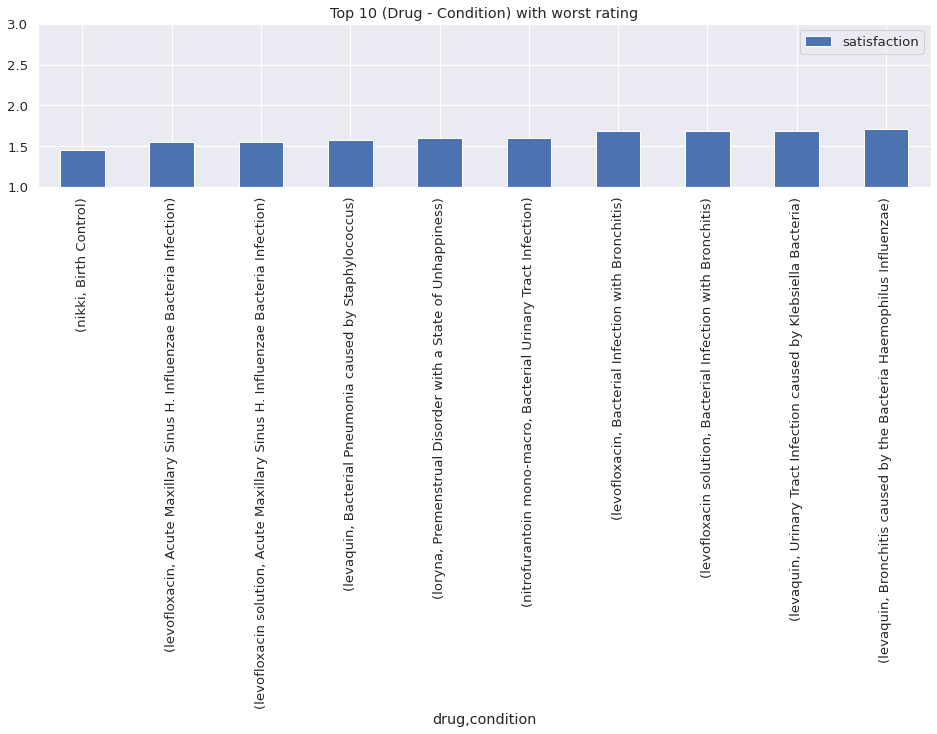

In [50]:
drugs_condition_rating = drugs.groupby(['drug', 'condition']).agg({
    'satisfaction': np.mean,
    'uniqueid': pd.Series.nunique
})

print("Number of pairs (Drug, Condition):", len(drugs_condition_rating))

print("Significant number of reviews: More than", drugs_condition_rating['uniqueid'].quantile(q=0.75), "reviews")

drugs_condition_rating = drugs_condition_rating[drugs_condition_rating['uniqueid'] > int(drugs_condition_rating['uniqueid'].quantile(q=0.75))]
# drugs_condition_rating.sort_values('rating', ascending=False)
top_drugs_condition_rating = drugs_condition_rating.nlargest(10, 'satisfaction')
plot = top_drugs_condition_rating.plot(y='satisfaction', kind='bar', figsize = (16, 3))
dummy = plt.title("Top 10 (Drug - Condition) with best rating") # Assigned to variable to prevent output
dummy = plt.ylim(4, 5) # Assigned to variable to prevent output

bottom_drugs_condition_rating = drugs_condition_rating.nsmallest(10, 'satisfaction')
plot = bottom_drugs_condition_rating.plot(y='satisfaction', kind='bar', figsize = (16, 3))
dummy = plt.title("Top 10 (Drug - Condition) with worst rating") # Assigned to variable to prevent output
dummy = plt.ylim(1, 3) # Assigned to variable to prevent output

## Temporal Analysis

Building a good prediction model is **no** trivial task. Temporal features ***could*** help a model to perform better if we can foresee some **temporal patterns**. We will analyze monthly patterns over different years of all the reviews.

In [51]:
def review_clean(reviews): 
    # changing to lower case
    lower = reviews.str.lower()
    
    # Replacing the repeating pattern of &#039;
    pattern_remove = lower.str.replace("&#039;", "")
    
    # Removing all the special Characters
    special_remove = pattern_remove.str.replace(r'[^\w\d\s]',' ')
    
    # Removing all the non ASCII characters
    ascii_remove = special_remove.str.replace(r'[^\x00-\x7F]+',' ')
    
    # Removing the leading and trailing Whitespaces
    whitespace_remove = ascii_remove.str.replace(r'^\s+|\s+?$','')
    
    # Replacing multiple Spaces with Single Space
    multiw_remove = whitespace_remove.str.replace(r'\s+',' ')
    
    # Replacing Two or more dots with one
    dataframe = multiw_remove.str.replace(r'\.{2,}', ' ')
    
    return dataframe

In [52]:
#df_data['review_clean'] = df_data['review'].apply(review_clean)
drugs['review_clean'] = review_clean(drugs['reviews'])

In [55]:
# Removing the stopwords
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
drugs['review_clean'] = drugs['review_clean'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [56]:
# Removing the word stems using the Snowball Stemmer
Snow_ball = SnowballStemmer("english")
drugs['review_clean'] = drugs['review_clean'].apply(lambda x: " ".join(Snow_ball.stem(word) for word in x.split()))

## Sentiment Analysis

We will analyze the sentiment of the reviews. We theorize that **the sentiment embedded on a review can be a key factor** to determine the review rating, the review impact on people (usefulCount), or how good a drug is for an specific condition. 

However, reviews can expose many different manifestations, such as: condition symptoms (usually negative), feelings before the drug (usually negative), feelings after the drug (could be positive or negative), side effects (usually negative), symptoms after the drug (could be positive or negative). This mix of manifestations could make any sentiment analysis method to struggle determining a single score for the entire review. Therefore, a aspect-based S.A. could be more viable (such as the ones used by Gräßer et al.).

For now, we are going to use Vader [1], a rule-based sentiment analysis approach available in Python NLTK. To **obtain a single sentiment score for every review** (-1|negative to 1|positive), and see how it correlates with ratings (spearman coeff.).

Before doing this, **text** must be processed:

- HTML characters are converted to legible text
- Punctuation signs are removed

[1] Gilbert, C. H. E. (2014). Vader: A parsimonious rule-based model for sentiment analysis of social media text. In Eighth International Conference on Weblogs and Social Media (ICWSM-14). Available at (20/04/16) http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf.

In [57]:
def sentiment(reviews):
    # Sentiment polarity of the reviews
    pol = []
    for i in reviews:
        analysis = TextBlob(i)
        pol.append(analysis.sentiment.polarity)
    return pol
drugs['sentiment'] = sentiment(drugs['reviews'])

drugs['sentiment_clean'] = sentiment(drugs['review_clean'])


In [59]:
np.corrcoef(drugs['sentiment'], drugs['satisfaction'])


array([[1.       , 0.2817206],
       [0.2817206, 1.       ]])

In [60]:
np.corrcoef(drugs['sentiment_clean'], drugs['satisfaction'])


array([[1.        , 0.19406179],
       [0.19406179, 1.        ]])

The Correlation coefficient between the sentiment of the uncleaned review with rating is greater than the cleaned review, so now lets try without the snowball stemmer and without removing the stopwords.

In [62]:
# Cleaning the reviews without removing the stop words and using snowball stemmer
drugs['review_clean_ss'] = review_clean(drugs['reviews'])
drugs['sentiment_clean_ss'] = sentiment(drugs['review_clean_ss'])


In [65]:
np.corrcoef(drugs['sentiment_clean_ss'], drugs['satisfaction'])


array([[1.        , 0.28177958],
       [0.28177958, 1.        ]])

In [66]:
drugs['condition'].value_counts().head(20)

Pain                                                         12973
Other                                                        11719
High Blood Pressure                                          11317
Neuropathic Pain                                             4901 
Type 2 Diabetes Mellitus                                     4062 
Birth Control                                                3793 
Bipolar Depression                                           3015 
Depression                                                   2394 
Underactive Thyroid                                          1938 
Chronic Pain                                                 1613 
Attention Deficit Disorder with Hyperactivity                1233 
Pain Originating From a Nerve                                1012 
Disorder characterized by Stiff, Tender & Painful Muscles    998  
Joint Damage causing Pain and Loss of Function               932  
Repeated Episodes of Anxiety                                 9

In [83]:
drugs.isna().sum()

age                   0    
condition             0    
drug                  0    
drugid                0    
easeofuse             0    
effectiveness         0    
reviews               0    
sentiment_rating      0    
sex                   0    
sides                 0    
usefulcount           0    
satisfaction          0    
uniqueid              0    
sentiment_rate        0    
review_clean          0    
sentiment             0    
sentiment_clean       0    
review_clean_ss       0    
sentiment_clean_ss    0    
count_word            0    
count_unique_word     0    
count_letters         0    
count_punctuations    0    
count_stopwords       0    
mean_word_len         13142
dtype: int64

# Feature Engineering

In [68]:
#Word count in each review
drugs['count_word']=drugs["review_clean_ss"].apply(lambda x: len(str(x).split()))

#Unique word count 
drugs['count_unique_word']=drugs["review_clean_ss"].apply(lambda x: len(set(str(x).split())))

#Letter count
drugs['count_letters']=drugs["review_clean_ss"].apply(lambda x: len(str(x)))

#punctuation count
drugs["count_punctuations"] = drugs["reviews"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))


#Number of stopwords
drugs["count_stopwords"] = drugs["reviews"].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))

#Average length of the words
drugs["mean_word_len"] = drugs["review_clean_ss"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

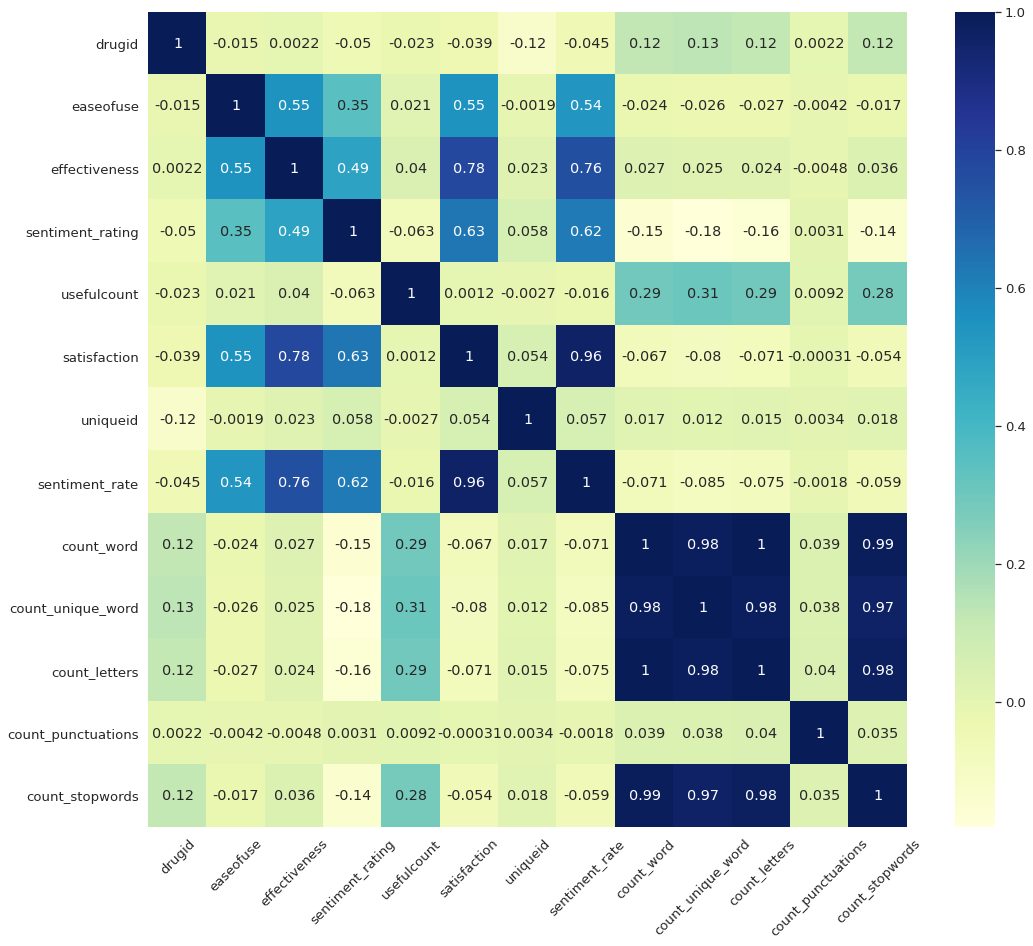

In [69]:
# Correlation Heatmap of the features engineered
plt.rcParams['figure.figsize'] = [17,15]
sns.set(font_scale = 1.2)
corr = drugs.select_dtypes(include = 'int64').corr()
sns_ = sns.heatmap(corr, annot = True, cmap = 'YlGnBu')
plt.setp(sns_.get_xticklabels(), rotation = 45);

In [70]:
# Label Encoding Drugname and Conditions
from sklearn.preprocessing import LabelEncoder
label_encoder_feat = {}
for feature in ['drug', 'condition']:
    label_encoder_feat[feature] = LabelEncoder()
    drugs[feature] = label_encoder_feat[feature].fit_transform(drugs[feature])

# Importing Libraries for the Machine Learning Model


In [96]:

from sklearn.model_selection import KFold, cross_val_score
#from lightgbm.sklearn import LGBMRegressor
#from sklearn.metrics import mean_squared_error


# Importing Libraries for the Machine Learning Model
from xgboost import XGBClassifier
from lightgbm import LGBMModel,LGBMClassifier, plot_importance
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_predict

In [91]:
# Defining Features and splitting the data as train and test set

features = drugs[['condition', 'usefulcount', 'sentiment',
                   'sentiment_clean_ss', 'count_word', 'count_unique_word', 'count_letters',
                   'count_punctuations', 'count_stopwords']]

target = drugs['satisfaction']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.3, shuffle=True, random_state = 42)
print ("The Train set size ", X_train.shape)
print ("The Test set size ", X_test.shape)

The Train set size  (69991, 9)
The Test set size  (29997, 9)


In [92]:
# Training Model - I
clf = LGBMClassifier(
        n_estimators=10000,
        learning_rate=0.10,
        num_leaves=30,
        subsample=.9,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
        )
model = clf.fit(X_train, y_train)

# Predictions
predictions = model.predict(X_test)
print ("The Accuracy of the model is : ", accuracy_score(y_test, predictions))
print ("The confusion Matrix is ")
confusion_matrix(y_test, predictions)

The Accuracy of the model is :  0.5579224589125579
The confusion Matrix is 


array([[5803,  154,  373,  500, 1460],
       [ 963,  918,  158,  228,  760],
       [1088,   91, 1570,  437, 1361],
       [ 948,   83,  251, 2181, 1883],
       [1339,  100,  327,  757, 6264]])

In [ ]:
# Feature Importance Plot using LGBM
plt.rcParams['figure.figsize'] = [12, 9]
sns.set(style = 'whitegrid', font_scale = 1.2)
plot_importance(model);

In [93]:
# Training Model - II
from sklearn.ensemble import RandomForestClassifier
import time

rfc = RandomForestClassifier(n_estimators=10)
training_start = time.perf_counter()
rfc.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = rfc.predict(X_test)
prediction_end = time.perf_counter()
acc_rfc = (preds == y_test).sum().astype(float) / len(preds)*100
rfc_train_time = training_end-training_start
rfc_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Random Forest Classifier's prediction accuracy is: %3.2f" % (acc_rfc))
print("Time consumed for training: %4.3f seconds" % (rfc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (rfc_prediction_time))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Scikit-Learn's Random Forest Classifier's prediction accuracy is: 58.46
Time consumed for training: 1.820 seconds
Time consumed for prediction: 0.13779 seconds


In [94]:
from sklearn.ensemble import GradientBoostingClassifier
gbk = GradientBoostingClassifier()
gbk.fit(X_train, y_train)

training_start = time.perf_counter()
gbk.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = gbk.predict(X_test)
prediction_end = time.perf_counter()
acc_gbk = (preds == y_test).sum().astype(float) / len(preds)*100
gbk_train_time = training_end-training_start
gbk_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's GBK Classifier's prediction accuracy is: %3.2f" % (acc_gbk))
print("Time consumed for training: %4.3f seconds" % (gbk_train_time))
print("Time consumed for prediction: %6.5f seconds" % (gbk_prediction_time))

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Scikit-Learn's GBK Classifier's prediction accuracy is: 40.71
Time consumed for training: 66.316 seconds
Time consumed for prediction: 0.24456 seconds


In [97]:
predictions = cross_val_predict(rfc, features, target, cv=3)
confusion_matrix(target, predictions)

array([[15095,  1484,  2491,  2535,  5889],
       [ 4227,   835,  1162,  1208,  2605],
       [ 5514,   889,  2333,  1936,  4562],
       [ 5517,   973,  2367,  2841,  6357],
       [ 8167,  1379,  3201,  4126, 12295]])

In [101]:
print("Precision:", precision_score(target, predictions, average='micro'))
print("Recall:",recall_score(target, predictions, average='micro'))

Precision: 0.3340300836100332
Recall: 0.3340300836100332


In [102]:
print("F1-Score:", f1_score(target, predictions, average='micro'))

F1-Score: 0.3340300836100332


In [104]:
# Classification report
import sklearn.metrics as metrics
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(target, predictions))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

           1       0.39      0.55      0.46     27494
           2       0.15      0.08      0.11     10037
           3       0.20      0.15      0.17     15234
           4       0.22      0.16      0.19     18055
           5       0.39      0.42      0.40     29168

    accuracy                           0.33     99988
   macro avg       0.27      0.27      0.27     99988
weighted avg       0.31      0.33      0.31     99988



In [106]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb.fit(y_test)
y_test1 = lb.transform(y_test)
y_pred1= lb.transform(preds)
roc_auc_score(y_test1, y_pred1, average="macro")

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

0.5628652248952513

In [108]:

from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp



statis=target
y = label_binarize(statis, classes=[0, 1, 2, 3, 4])
n_classes = y.shape[1]


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test1[:, i], y_pred1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test1.ravel(), y_pred1.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

<Figure size 864x648 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver operating characteristic example')

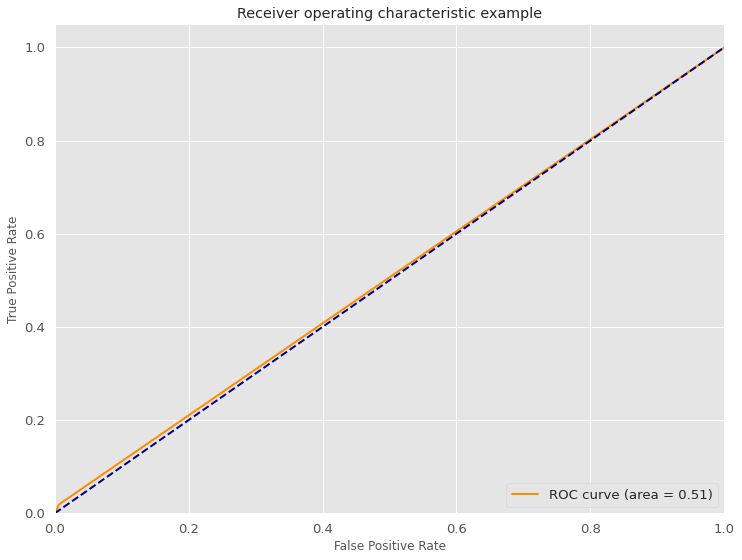

In [109]:

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

<Figure size 864x648 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Some extension of Receiver operating characteristic to multi-class')

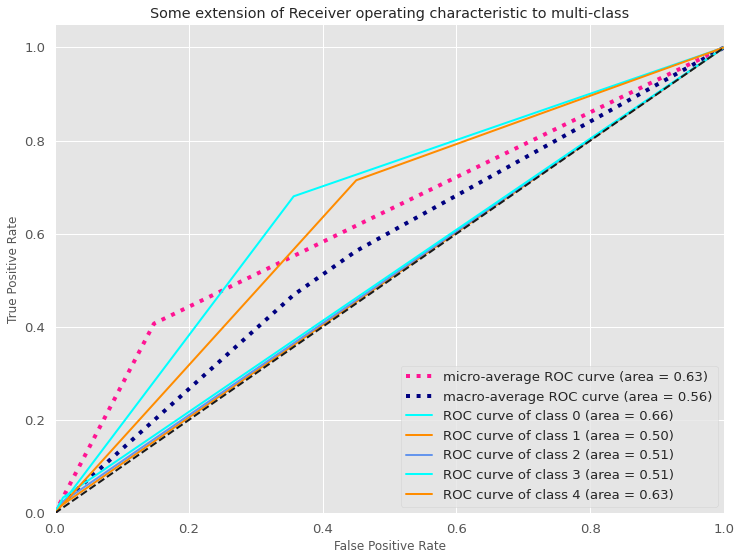

In [110]:
from scipy import interp
from itertools import cycle

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()